# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
#!pip install vecstack

In [3]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from tqdm import notebook
from vecstack import stacking

import re


import transformers

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer



import matplotlib.pyplot as plt
import seaborn as sns


import spacy
spacy.cli.download("en_core_web_sm")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
df = pd.read_csv('D:\Data sets для проектов\Проект для «Викишоп» с BERT\\toxic_comments.csv', index_col=0)

In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


В нашем DataFrame 159292 строк, один столбец типа int64, второй столбец типа object. Nan в DataFrame нет.

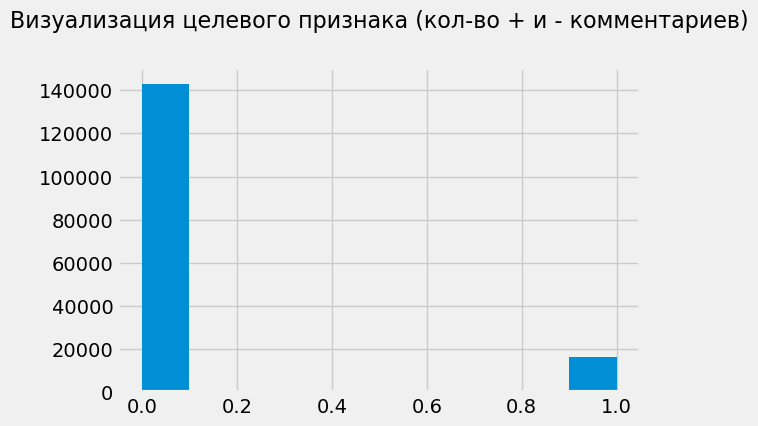

In [7]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [6,4]

plt.title('Визуализация целевого признака (кол-во + и - комментариев)', fontsize=16, y= 1.1)
plt.hist(df['toxic'])

plt.show()

Визуальное представление негативных и положительных комментариев.

In [8]:
col_per = {'Количество + и - комментариев': [df.toxic.value_counts()[0], 
                                             df.toxic.value_counts()[1]], 
           
           'Процент + и - комментариев': [df.toxic.value_counts()[0] * 100 / len(df), 
                                          df.toxic.value_counts()[1] * 100 / len(df)]}

df_col_per= pd.DataFrame(data=col_per)
df_col_per

,Количество + и - комментариев,Процент + и - комментариев
0,143106,89.838787
1,16186,10.161213


Числовое представление негативных и положительных комментариев, а именно:

    - Негативные комментариев 143106 - что составляет 89.8 % от всех комментариев
    - Положительные комментариев 16186 - что составляет 10.2 % от всех комментариев

In [9]:
df.text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Текст до обработки

In [10]:
%%time
nlp = spacy.load('en_core_web_sm')

new_text = []
for i in df.text: 
    # Удаляем неалфавитные символы
    text = re.sub("[^a-zA-Z]"," ",i) 
    # Удаляем начальные и конечные пробелы
    text = re.sub(r"^\s+|\s+$", "", text)
    # Заменяем несколько пробелов одним пробелом
    text =re.sub(r"\s+", " ", text)
    
    # Удаляем одиночные символов
    text = [word for word in text.split() if len(word) > 1]
    # Понижаем регистр символов 
    doc = [text_low.lower() for text_low in text]
    
    doc = nlp(" ".join(doc))
    
    # Удаляем стоп-слова
    doc = [word for word in doc if word.is_stop != True]   
    new_text.append(" ".join([token.lemma_ for token in doc]))

CPU times: total: 23min 40s
Wall time: 23min 40s


In [11]:
new_text[0]

'explanation edit username hardcore metallica fan revert weren vandalism closure gas vote new york doll fac don remove template talk page retire'

Текст после обработки

In [12]:
df_1 = pd.DataFrame(new_text, columns=['lemm_text'])
df_lemm = pd.concat([df.reset_index(drop=True) , df_1], axis=1)
df_lemm

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,second time ask view completely contradict cov...
159288,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing talk page
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm s actual article prostitution ring...
159290,And it looks like it was actually you who put ...,0,look like actually speedy version delete look


In [13]:
df_lemm.lemm_text[0]

'explanation edit username hardcore metallica fan revert weren vandalism closure gas vote new york doll fac don remove template talk page retire'

**Вывод**

В нашем DataFrame 159292 строк, 143106 - негативные комментарии и 16186 - положительные комментарии. Из чего можно сделать вывод, что наш DataFrame состоит в основном негативные комментарии. Значений NaN нет.

## Обучение

### Стэкинг

In [14]:
models = [Perceptron(),
          RidgeClassifier(),
          LogisticRegression(max_iter=1000, n_jobs=-1),
          SGDClassifier(n_jobs=-1),
          PassiveAggressiveClassifier(n_jobs=-1),
          LinearSVC(dual = True, max_iter=100000)
]

На начальном этапе применяем Стэкинг

### Предобработка с помощью BERT 

In [15]:
df_tweets_BERT = df_lemm.sample(n=50000, random_state=69).reset_index(drop=True) 

Берем 50000 строк из общего числа df, для сокращения времени обучения нейронной сети. 

In [16]:
df_tweets_BERT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       50000 non-null  object
 1   toxic      50000 non-null  int64 
 2   lemm_text  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [17]:
pd.DataFrame(df_tweets_BERT.toxic.value_counts())

,toxic
0,44945
1,5055


Соотношение 0 и 1 примерно одинаковое, по отношению к исходному df.

In [18]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, 
                                                    transformers.BertTokenizer, 
                                                    'unitary/toxic-bert')


tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Опытным путем было доказано, что bert-base-uncased и bert-base-cased в нашем случае не подходят, т к они не предназначены для токсического текста и выдают низкую метрику f1. Поэтому, применяем модель unitary/toxic-bert для токсического текста.

In [19]:
tokeniz = tokenizer_class.from_pretrained(pretrained_weights)

In [20]:
%%time
token_lens_df_1 = []
for txt in df.text:
    tokens = tokeniz.encode(txt, max_length=512, truncation=True)
    token_lens_df_1.append(len(tokens))

CPU times: total: 3min 50s
Wall time: 3min 50s


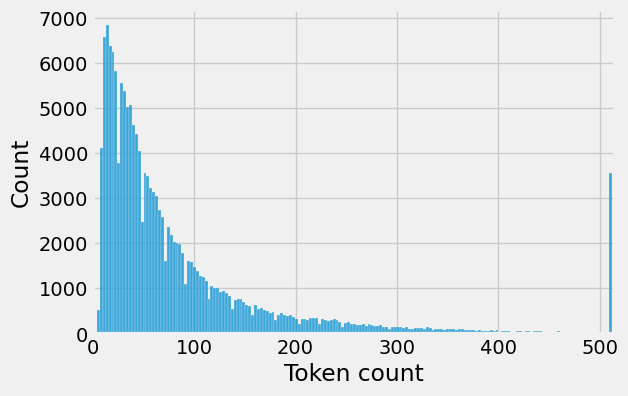

In [21]:
sns.histplot(token_lens_df_1)
plt.xlim([0, 515]);
plt.xlabel('Token count');

Из графика можно сделать вывод, что большинство комментариев длиной до 100 токенов. Т к мы ограничили длину в 512 токенов, то на отметке в 512 у нас образовался всплеск, а это означает, что приличное число комментариев превышает 512 токенов.

In [22]:
tokenized = df_tweets_BERT['text'].apply((lambda x: tokenizer.encode(x, truncation = True, add_special_tokens=True)))

Преобразуем каждое предложение в список идентификаторов

In [23]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными.

In [24]:
attention_mask = np.where(padded != 0, 1, 0)

Поясним модели, что нули не несут значимой информации и укажем нулевые и не нулевые значения

In [25]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model.to(device);

Инициализируем обработку на GPU, для ускорения выполнения кода.

In [26]:
%%time
batch_size = 10
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])                         # преобразуем данные
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])    # преобразуем маску

    with torch.no_grad():
        batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))   # Чтобы получить эмбеддинги для батча, 
                                                                               # передадим модели данные и маску

    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())             # Градиенты не нужны (увеличение скорости обучения)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: total: 54min 50s
Wall time: 54min 54s


In [27]:
features = np.concatenate(embeddings)

Собираем все эмбеддинги в матрицу признаков вызовом функции concatenate

In [28]:
labels = df_tweets_BERT.toxic

train_features, test_features, train_labels, test_labels = train_test_split(features.copy(), 
                                                                            labels.copy(), 
                                                                            test_size=0.2, 
                                                                            random_state=69,
                                                                            shuffle=True)       # default=True

Разбиваем df на train и test, в соотношении 80 / 20

In [29]:
%%time
S_train_BERT, S_test_BERT = stacking(models,     
                           
                                     train_features, train_labels, test_features,   
                           
                                     regression=False, 

                                     mode='oof_pred_bag', 

                                     needs_proba=False,

                                     save_dir=None, 

                                     metric=f1_score, 

                                     n_folds=5, 

                                     stratified=True,

                                     shuffle=True,  

                                     random_state=69,    

                                     verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [f1_score]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [Perceptron]
    fold  0:  [0.94242804]
    fold  1:  [0.93905473]
    fold  2:  [0.91778426]
    fold  3:  [0.88466757]
    fold  4:  [0.94567901]
    ----
    MEAN:     [0.92592272] + [0.02281845]
    FULL:     [0.92651279]

model  1:     [RidgeClassifier]
    fold  0:  [0.94375000]
    fold  1:  [0.94559099]
    fold  2:  [0.94894147]
    fold  3:  [0.93935644]
    fold  4:  [0.95463021]
    ----
    MEAN:     [0.94645382] + [0.00512776]
    FULL:     [0.94645081]

model  2:     [LogisticRegression]
    fold  0:  [0.94447910]
    fold  1:  [0.93875000]
    fold  2:  [0.93683552]
    fold  3:  [0.93574548]
    fold  4:  [0.94854309]
    ----
    MEAN:     [0.94087064] + [0.00487717]
    FULL:     [0.94088301]

model  3:     [SGDClassifier]
    fold  0:  [0.92109877]
    fold  1:  [0.92535393]
    fold  2:  [0.92056075]
    fold  3:  [0.91013825]
    

Лучшая метрика на модели RidgeClassifier f1 = 0.946, но на LogisticRegression f1 = 0.940, что примерно одинаково.

### Разбиваем наш df

In [30]:
X = df_lemm.lemm_text
y = df_lemm.toxic

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 69)

Разбили df в соотношении 75 / 25. 75% - train и 25% - test выборки.

### Обучаем модель с мешком слов

In [31]:
# импортируем модуль
count = CountVectorizer(stop_words="english", ngram_range=(1,2))

# проводим преобразование текста
matrix_train = count.fit_transform(x_train)  
matrix_test = count.transform(x_test)

matrix_train.shape, matrix_test.shape

((119469, 1857676), (39823, 1857676))

Создаем мешок слов

In [32]:
%%time
S_train, S_test = stacking(models,     
                           
                           matrix_train, y_train, matrix_test,   
                           
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=f1_score, 
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=69,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [f1_score]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [Perceptron]
    fold  0:  [0.72344730]
    fold  1:  [0.72474438]
    fold  2:  [0.74708333]
    fold  3:  [0.72934233]
    fold  4:  [0.75652174]
    ----
    MEAN:     [0.73622782] + [0.01320838]
    FULL:     [0.73595529]

model  1:     [RidgeClassifier]
    fold  0:  [0.66556992]
    fold  1:  [0.67455896]
    fold  2:  [0.66234368]
    fold  3:  [0.64911463]
    fold  4:  [0.65990316]
    ----
    MEAN:     [0.66229807] + [0.00825318]
    FULL:     [0.66229661]

model  2:     [LogisticRegression]
    fold  0:  [0.76606684]
    fold  1:  [0.76787372]
    fold  2:  [0.76634214]
    fold  3:  [0.74622005]
    fold  4:  [0.76883840]
    ----
    MEAN:     [0.76306823] + [0.00848480]
    FULL:     [0.76307349]

model  3:     [SGDClassifier]
    fold  0:  [0.76016636]
    fold  1:  [0.76105384]
    fold  2:  [0.75965074]
    fold  3:  [0.74644006]
    

C:\Users\seryo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    fold  1:  [0.78032787]


C:\Users\seryo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    fold  2:  [0.77535916]
    fold  3:  [0.76190476]


C:\Users\seryo\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


    fold  4:  [0.77304653]
    ----
    MEAN:     [0.77331748] + [0.00617354]
    FULL:     [0.77332633]

CPU times: total: 3h 21min 20s
Wall time: 1h 9min 10s


Лучшая метрика на модели LinearSVC f1 = 0.773 

### Обучаем модель с TF-IDF

In [33]:
# импортируем модуль TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,2))

#преобразуем текст
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

tfidf_train.shape, tfidf_test.shape

((119469, 1857676), (39823, 1857676))

Создаем TF-IDF, проверяем размер матрицы  

In [34]:
%%time
S_train, S_test = stacking(models,     
                           
                           tfidf_train, y_train, tfidf_test,   
                           
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=f1_score, 
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=69,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [f1_score]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [Perceptron]
    fold  0:  [0.75875029]
    fold  1:  [0.74518304]
    fold  2:  [0.76183812]
    fold  3:  [0.74794145]
    fold  4:  [0.76589986]
    ----
    MEAN:     [0.75592255] + [0.00801962]
    FULL:     [0.75602270]

model  1:     [RidgeClassifier]
    fold  0:  [0.66093960]
    fold  1:  [0.66773333]
    fold  2:  [0.67126193]
    fold  3:  [0.65252417]
    fold  4:  [0.64818304]
    ----
    MEAN:     [0.66012841] + [0.00875174]
    FULL:     [0.66017339]

model  2:     [LogisticRegression]
    fold  0:  [0.62669997]
    fold  1:  [0.62329719]
    fold  2:  [0.63784082]
    fold  3:  [0.62099694]
    fold  4:  [0.61753210]
    ----
    MEAN:     [0.62527340] + [0.00695839]
    FULL:     [0.62530549]

model  3:     [SGDClassifier]
    fold  0:  [0.49584232]
    fold  1:  [0.49723077]
    fold  2:  [0.52418380]
    fold  3:  [0.50199448]
    

Лучшая метрика на модели LinearSVC f1 = 0.766

### Обучаем модель с HashingVectorizer

Данный подход является односторонней функцией, поэтому нет способа преобразовать кодировку обратно в слово. В проекте не стоит задача двусторонней функции(преобразование обратно в слово), поэтому примением HashingVectorizer в проекте.

In [35]:
def hash_vector(x_train, x_test, y_train):
    
    n_featur = 0
    for featur in range(100_000, 2_100_000, 100_000):
        vector = HashingVectorizer(n_features = featur, lowercase=False)

        HashingVectorizer_train = vector.fit_transform(x_train)
        HashingVectorizer_test = vector.transform(x_test)
        
        
    best_score_HashingVectorizer = 0
    lr_c_HashingVectorizer = 0

    for i in range(1, 31, 1):
        model = LogisticRegression(C=i, n_jobs=-1, random_state=69)
        scores_1 = cross_val_score(model, 
                                   HashingVectorizer_train, 
                                   y_train, 
                                   cv=5,       
                                   n_jobs = -1,
                                   scoring='f1').mean()

        if scores_1 > best_score_HashingVectorizer:
            best_score_HashingVectorizer = scores_1
            lr_c_HashingVectorizer = i
            n_featur = featur


    return n_featur, best_score_HashingVectorizer, lr_c_HashingVectorizer, 

Написали функцию, с перебором features в HashingVectorizer и С в LogisticRegression

In [36]:
%%time
n_features_hash_vec, best_score_, lr_c_ = hash_vector(x_train, x_test, y_train)

CPU times: total: 57.2 s
Wall time: 28min 41s


In [37]:
n_features_hash_vec, best_score_, lr_c_

(2000000, 0.7819576765062328, 24)

In [38]:
vector = HashingVectorizer(n_features=n_features_hash_vec, lowercase=False)

HashingVectorizer_train = vector.fit_transform(x_train)
HashingVectorizer_test = vector.transform(x_test)

In [39]:
%%time
S_train, S_test = stacking(models,     
                           
                           HashingVectorizer_train, y_train, HashingVectorizer_test,   
                           
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=f1_score, 
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=69,    
         
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [f1_score]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [Perceptron]
    fold  0:  [0.73059361]
    fold  1:  [0.73394872]
    fold  2:  [0.73714403]
    fold  3:  [0.72141119]
    fold  4:  [0.73662294]
    ----
    MEAN:     [0.73194410] + [0.00575700]
    FULL:     [0.73190999]

model  1:     [RidgeClassifier]
    fold  0:  [0.69396217]
    fold  1:  [0.70010288]
    fold  2:  [0.69810354]
    fold  3:  [0.68452536]
    fold  4:  [0.68192458]
    ----
    MEAN:     [0.69172370] + [0.00726309]
    FULL:     [0.69176276]

model  2:     [LogisticRegression]
    fold  0:  [0.72979098]
    fold  1:  [0.72686117]
    fold  2:  [0.72808989]
    fold  3:  [0.71989924]
    fold  4:  [0.71929382]
    ----
    MEAN:     [0.72478702] + [0.00434318]
    FULL:     [0.72479509]

model  3:     [SGDClassifier]
    fold  0:  [0.63741722]
    fold  1:  [0.63653899]
    fold  2:  [0.66289105]
    fold  3:  [0.64234778]
    

Лучшая метрика на модели LinearSVC f1 = 0.780

## Лучшая модель

In [43]:
%%time
best_score_LinearSVC = 0
lr_c_LinearSVC = 0

for i in range(1, 31, 1):
    model = LinearSVC(C=i, random_state=69, max_iter=100_000)
    scores_LinearSVC = cross_val_score(model, 
                                       HashingVectorizer_train, 
                                       y_train, 
                                       cv=5,       
                                       n_jobs = -1,
                                       scoring='f1').mean()

    if scores_LinearSVC > best_score_LinearSVC:
        best_score_LinearSVC = scores_LinearSVC
        lr_c_LinearSVC = i

        
best_score_LinearSVC, lr_c_LinearSVC

CPU times: total: 2.91 s
Wall time: 4min 1s


(0.7837177498127809, 2)

In [44]:
%%time
model = LinearSVC(C = lr_c_LinearSVC, random_state=69)
model.fit(HashingVectorizer_train, y_train)
pred_linear_svc = model.predict(HashingVectorizer_test)
f1_score(y_test, pred_linear_svc)

CPU times: total: 1.2 s
Wall time: 1.21 s


0.7837016574585635

Из HashingVectorizer, TfidfVectorizer, CountVectorizer лучшая метрика f1 на HashingVectorizer модель LinearSVC f1 = 0.783.

In [45]:
%%time
best_score_ridge_classifier = 0
lr_c_ridge_classifier = 0

for i in range(1, 31, 1):
    model = RidgeClassifier(alpha=i, random_state=69, max_iter=100_000)
    scores_ridge_classifier = cross_val_score(model, 
                                              train_features, 
                                              train_labels, 
                                              cv=5,       
                                              n_jobs = -1,
                                              scoring='f1').mean()

    if scores_ridge_classifier > best_score_ridge_classifier:
        best_score_ridge_classifier = scores_ridge_classifier
        lr_c_ridge_classifier = i

        
best_score_ridge_classifier, lr_c_ridge_classifier

CPU times: total: 3.03 s
Wall time: 36.3 s


(0.9470729871978614, 22)

In [46]:
%%time
model = RidgeClassifier(alpha = lr_c_ridge_classifier, random_state=69)
model.fit(train_features, train_labels)
pred = model.predict(test_features)
f1_score(test_labels, pred)

CPU times: total: 1 s
Wall time: 241 ms


0.9414587332053743

**Метрика f1 = 0.941** на модели RidgeClassifier с обработкой текста с помощью 'unitary/toxic-bert'

## Выводы

В данном проекте были реализованы различные архитектуры предобработки токсического текста с помощью BERT, HashingVectorizer, TfidfVectorizer, CountVectorizer. Из всех архитектур, лучший показатель у BERT у модели 'unitary/toxic-bert' метрика f1 = 0.941. Остальные архитектуры показали примерно одинаковый результат метрика f1 в районе 0.75 - 0.78